### Imports

In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sklearn
# import fastai
# from fastai.vision.all import *
import time
from PIL import Image
from torch.utils.data import DataLoader
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# Load a dataset into a Pandas Dataframe

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
kaggle_path = './kaggle/input/csiro-biomass/train.csv'
local_path = '/Users/guytabennett-jones/code/me/ai/kaggle/biomass/input/train.csv'
dataset_df = pd.read_csv(local_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1785, 9)


In [3]:
train_pivot = dataset_df.pivot(
    index='image_path',
    columns='target_name',
    values='target'
).reset_index()
metadata_cols = [
    'Sampling_Date','Species', 'image_path',
    'Pre_GSHH_NDVI','Height_Ave_cm','State',
]
metadata = dataset_df[metadata_cols].drop_duplicates(subset='image_path')
dataset_df = pd.merge(metadata, train_pivot, on='image_path')
dataset_df.head()

,Sampling_Date,Species,image_path,Pre_GSHH_NDVI,Height_Ave_cm,State,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,2015/9/4,Ryegrass_Clover,train/ID1011485656.jpg,0.62,4.6667,Tas,0.0000,31.9984,16.2751,48.2735,16.2750
1,2015/4/1,Lucerne,train/ID1012260530.jpg,0.55,16.0000,NSW,0.0000,0.0000,7.6000,7.6000,7.6000
2,2015/9/1,SubcloverDalkeith,train/ID1025234388.jpg,0.38,1.0000,WA,6.0500,0.0000,0.0000,6.0500,6.0500
3,2015/5/18,Ryegrass,train/ID1028611175.jpg,0.66,5.0000,Tas,0.0000,30.9703,24.2376,55.2079,24.2376
4,2015/9/11,Ryegrass,train/ID1035947949.jpg,0.54,3.5000,Tas,0.4343,23.2239,10.5261,34.1844,10.9605


### Data investigation

Dry_Clover_g: -0.127
Dry_Dead_g: -0.074
Dry_Green_g: 0.639
Dry_Total_g: 0.492
GDM_g: 0.589


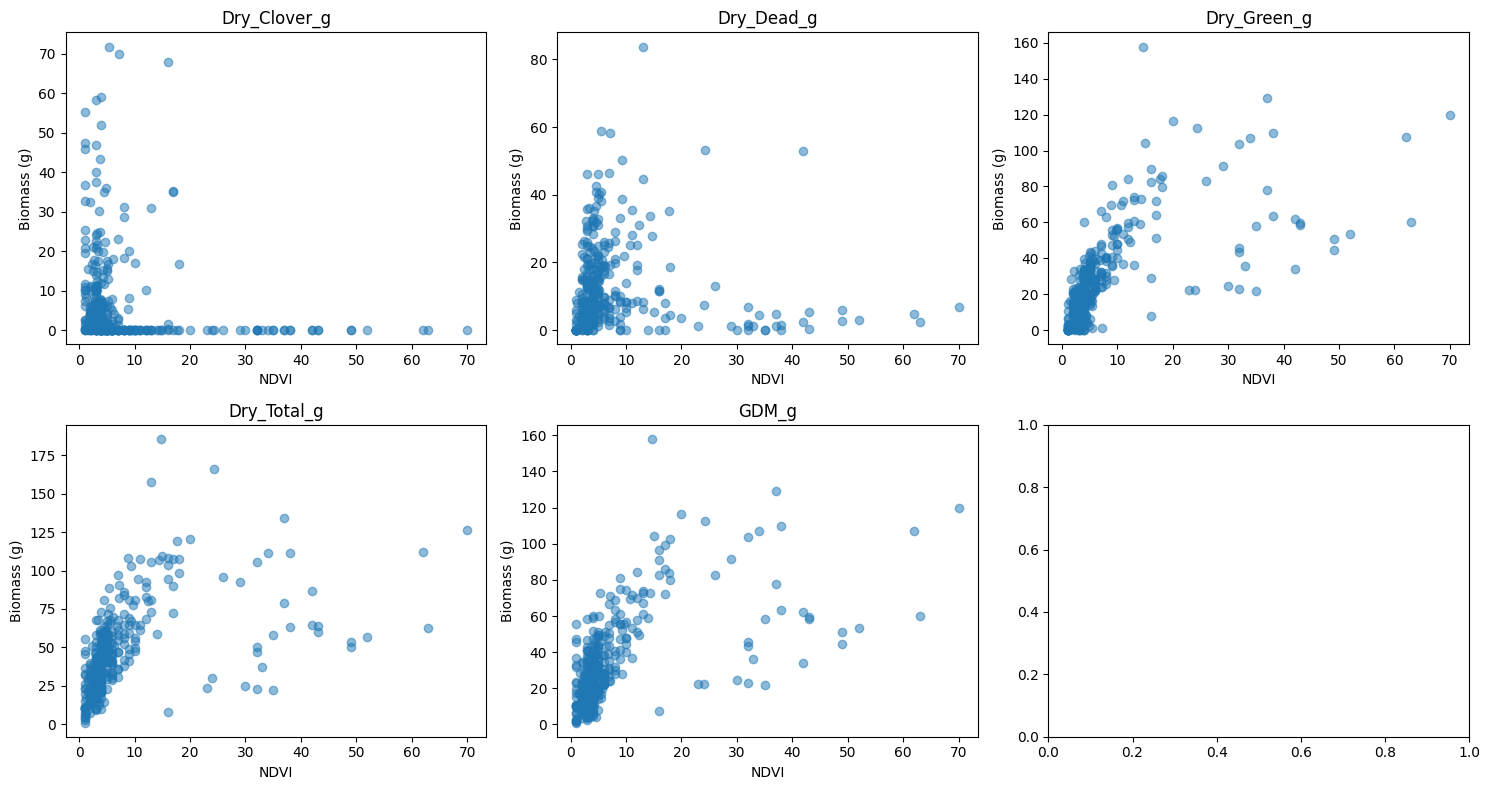

In [3]:
# df = dataset_df
# df['ndvi_height'] = df['Pre_GSHH_NDVI'] * df['Height_Ave_cm']
# # Check correlation between NDVI and each target type
# for target_name in df['target_name'].unique():
#     subset = df[df['target_name'] == target_name]
#     corr = subset['ndvi_height'].corr(subset['target'])
#     print(f"{target_name}: {corr:.3f}")

# # Visualize NDVI vs target for each type
# fig, axes = plt.subplots(2, 3, figsize=(15, 8))
# axes = axes.flatten()

# for i, target_name in enumerate(df['target_name'].unique()):
#     subset = df[df['target_name'] == target_name]
#     axes[i].scatter(subset['Height_Ave_cm'], subset['target'], alpha=0.5)
#     axes[i].set_xlabel('NDVI')
#     axes[i].set_ylabel('Biomass (g)')
#     axes[i].set_title(target_name)
    
# plt.tight_layout()
# plt.show()


In [64]:
dataset_df.Species.unique()

array(['Ryegrass_Clover', 'Lucerne', 'SubcloverDalkeith', 'Ryegrass',
       'Phalaris_Clover', 'SubcloverLosa', 'Clover', 'Fescue_CrumbWeed',
       'Phalaris_Ryegrass_Clover', 'Phalaris', 'WhiteClover', 'Fescue',
       'Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed',
       'Phalaris_Clover_Ryegrass_Barleygrass_Bromegrass', 'Mixed'],
      dtype=object)

### Pytorch

In [65]:
# Standardize: Calculate mean and std for each target column (save these!)
# target_cols = ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']
# target_mean = train_pivot[target_cols].mean().values
# target_std = train_pivot[target_cols].std().values


In [4]:
local_path = '/Users/guytabennett-jones/code/me/ai/kaggle/biomass/input'
kaggle_path = '/kaggle/input/csiro-biomass/'
class BiomassDataset(torch.utils.data.Dataset):
    def __init__(self, df, base_path, transform=None):
        self.df = df
        self.base_path = base_path
        self.transform = transform
        self.target_cols = ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = local_path + self.df.iloc[idx]['image_path']
        targets = self.df.iloc[idx][self.target_cols].values.astype('float32')
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(targets, dtype=torch.float32)

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])
# Create dataset and dataloader
# dataset = BiomassDataset(train_pivot, '/kaggle/input/csiro-biomass/', transform=transform)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)


In [68]:
# dataset_df[['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']].describe()

,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
count,357.000000,357.000000,357.000000,357.000000,357.000000
mean,6.649692,12.044548,26.624722,45.318097,33.274414
std,12.117761,12.402007,25.401232,27.984015,24.935822
min,0.000000,0.000000,0.000000,1.040000,1.040000
25%,0.000000,3.200000,8.800000,25.271500,16.026100
50%,1.423500,7.980900,20.800000,40.300000,27.108200
75%,7.242900,17.637800,35.083400,57.880000,43.675700
max,71.786500,83.840700,157.983600,185.700000,157.983600


In [9]:
import torch.nn as nn
import timm
from torchvision import models

# Load pretrained ResNet50
model = models.resnet50(weights=True)
# model = timm.tf_efficientnetv2_m(weights=True)
# model = MultiTaskModel(num_states=4).to(device)

# Freeze the pretrained layers (transfer learning)
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer for regression
# ResNet50's final layer is called 'fc' and has 2048 input features
model.fc = nn.Linear(model.fc.in_features, 5)  # Output 1 value (biomass)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = torch.nn.MSELoss()

/Users/guytabennett-jones/code/me/ai/ai-venv-3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/guytabennett-jones/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:19<00:00, 5.34MB/s]


### Feature Engineering

In [29]:
dataset_df['month'] = pd.to_datetime(dataset_df['Sampling_Date']).dt.month
dataset_df.drop(['Sampling_Date'], axis=1, inplace=True)

# One-hot encode State
dataset_df = pd.get_dummies(dataset_df, columns=['State'], prefix='state')


### Create datasets

In [6]:
# Split sets
train_df, val_df = sklearn.model_selection.train_test_split(dataset_df, train_size=0.8, random_state=42, shuffle=True)

# train_size = int(0.8 * len(dataset_df))
# val_size = len(dataset_df) - train_size
# train_df = dataset_df.iloc[:train_size]
# val_df = dataset_df.iloc[train_size:]

# Create datasets with different transforms
kaggle_path = '/kaggle/input/csiro-biomass/'
local_path =  '/Users/guytabennett-jones/code/me/ai/kaggle/biomass/input/'
train_dataset = BiomassDataset(train_df, local_path, transform=train_transform)
val_dataset = BiomassDataset(val_df, local_path, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

### Support Functions

In [7]:
def print_result(train_loss, val_loss, train_loader, val_loader, epoch_start, epoch, num_epochs):
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    epoch_time = time.time() - epoch_start
    mins, secs = divmod(epoch_time, 60)
    
    # Print results
    print(f'Epoch {epoch+1}/{num_epochs} - '
          f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Time: {int(mins)}m {int(secs)}s')

def train_model(images, targets, validation=False):
    images, targets = images.to(device), targets.to(device)
    
    if not validation: optimizer.zero_grad() 
    outputs = model(images)
    loss = criterion(outputs, targets)
    if not validation:
        loss.backward()
        optimizer.step()
    return loss.item()

### Learning rate

KeyError: 'target_name'

In [73]:
# def find_lr(model, train_loader, start_lr=1e-7, end_lr=10, num_iter=100):
#     optimizer = torch.optim.Adam(model.parameters(), lr=start_lr)
#     lr_mult = (end_lr / start_lr) ** (1/num_iter)
#     lrs,losses = [],[]
#     model.train()
#     for i,(images,targets) in enumerate(train_loader):
#         print('.')
#         if i >= num_iter: break
#         optimizer.zero_grad()
#         outputs = model(images.to(device))
#         loss = criterion(outputs, targets.to(device))
#         loss.backward()
#         optimizer.step()
#         lrs.append(optimizer.param_groups[0]['lr'])
#         losses.append(loss.item())
#         for g in optimizer.param_groups: g['lr'] *= lr_mult
#     return lrs,losses

In [74]:
# lrs, losses = find_lr(model, train_loader, start_lr=1e-7, end_lr=2, num_iter=36)

KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'image_path'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_49/3797156351.py", line 12, in __getitem__
    img_path = '/kaggle/input/csiro-biomass/' + self.df.iloc[idx]['image_path']
                                                ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/series.py", line 1121, in __getitem__
    return self._get_value(key)
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/series.py", line 1237, in _get_value
    loc = self.index.get_loc(label)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py", line 3812, in get_loc
    raise KeyError(key) from err
KeyError: 'image_path'


In [ ]:
# plt.plot(lrs, losses)
# plt.xscale('log')
# plt.xlabel('Learning Rate')
# plt.ylabel('Loss')
# plt.grid(True)
# lrs, losses
# # print(f"Total batches in train_loader: {len(train_loader)}")
# # print(f"Batch size: {train_loader.batch_size}")


### Train Model

In [23]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0007)

In [24]:
# https://data.mendeley.com/datasets/nj72kmdj77/1/files/9132749d-03a3-4535-8c05-447ebb58da27
## # Training loop for 1 epoch
num_epochs = 25

for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    train_loss = 0
    for images, targets in train_loader:
        last_loss = train_model(images, targets)
        train_loss += last_loss
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            val_loss += train_model(images, targets, validation=True)
    
    print_result(train_loss, val_loss, train_loader, val_loader, epoch_start, epoch, num_epochs)
    
print(f'Training complete! Final batch loss: {last_loss.item():.4f}')


KeyError: "None of [Index(['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g'], dtype='object')] are in the [index]"

resnet50 322
With aug Val Loss: 404.3574  
Epoch 10 / 10  →  Train Loss: 404.0312   |   Val Loss: 526.2535  

✅ Training complete!  
Final batch loss: **730.4459**

In [ ]:
# Get the predictions for testdata
with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds.extend(outputs.cpu().numpy())
predictions = np.array(preds).flatten()

In [ ]:
# Submit
sample_submission_df = pd.read_csv('/kaggle/input/csiro-biomass/sample_submission.csv')
sample_submission_df['target'] = predictions
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()